In [8]:
import numpy as np
import matplotlib.pyplot as plt
import preprocessing as pp
import implementations as imp
import helpers as hlp
import os
from functions import *
import csv

%load_ext autoreload
%autoreload 2

## Data cleaning

In [9]:
path = '/Users/maelynenguyen/Desktop/dataset_to_release/'
x_train_, x_test_, y_train_, train_ids_, test_ids_ = hlp.load_csv_data(path)

In [10]:
x, x_submit, y = pp.clean_data_final(x_train_, y_train_, x_test_)

X_train = np.concatenate((x, np.zeros((x.shape[0], 1)) + 1), axis=1)
X_test = np.concatenate((x_submit, np.zeros((x_submit.shape[0], 1)) + 1), axis=1)


assert x.shape[1] + 1 == X_train.shape[1]

Y_train = y.copy()
Y_train = np.where(y == -1, 0, 1)
Y_train = Y_train.astype(int) 


Unknown values replaced with NaN, according to the documentation
Max median NaN score rows :  0.6060963867246555
Max median NaN score columns :  0.7652518774030354
Number of rows dropped because of a NaN score > 0.5:  37081
Number of columns dropped because of a NaN score > 0.5:  150
Number of columns with std < 0.1: 5
Number of columns with correl_coef > 0.95: 11
Handling NaN values...
Data clipped between 5th and 95th percentiles
Number of columns with std < 0.1 after cleaning: 11
Number of columns with corr_coef> 0.95 after cleaning: 14
The data has been cleaned and standardized
The cleaned x_train data has the following shape:  (291054, 130)
The cleaned y_train has the following shape:  (291054,)
The cleaned x_test has the following shape:  (109379, 130)


In [11]:
x_train, y_train_split, x_test, y_test_split = pp.split_data(X_train, y, 0.8) # 80% training, 20% testing


y_train = y_train_split.copy()
y_train = np.where(y_train_split == -1, 0, 1).astype(int) 

y_test = y_test_split.copy()
y_test = np.where(y_test_split == -1,0,1).astype(int)

## Logistic Regression

# Hyperparameter tuning

In [30]:
param_grid = {
    "max_iters": [1500],
    "gamma": [1, 0.1, 0.001],
    "lambda_": [1e-4, 1e-5, 1e-6],
}

In [8]:
w_grid, best_params_logistic, losses = grid_search_logistic_regression(y_train, x_train, param_grid, np.zeros(x_train.shape[1]))

Max Iters: 1500, Gamma: 1, Avg Loss: 0.22988858420150513
Max Iters: 1500, Gamma: 0.1, Avg Loss: 0.22999879896363645
Max Iters: 1500, Gamma: 0.001, Avg Loss: 0.4901988597087352


In [39]:
print("Best hyperparameters found: ", best_params_logistic)

Best hyperparameters found:  {'max_iters': 1500, 'gamma': 1}


## Prediction

In [95]:
w_log, loss, losses = imp.logistic_regression(y_train, x_train, np.zeros(x_train.shape[1]), 1500, 1, True)

# Determining the Threshold

In [109]:
y_train_log = imp.sigmoid(x_train @ w_log)
thr_ = best_threshold(y_train_log, y_train_split) 
print("Optimal Threshold for the Logistic Regression: ", thr_)
#y_train_log = np.where(y_train_log > thr_, 1, -1)

Optimal Threshold for the Logistic Regression:  0.2


In [105]:
y_test_log = imp.sigmoid(x_test @ w_log)
y_test_log = np.where(y_test_log > thr_, 1, -1)

In [111]:
print("F1 score",f1_score_(y_test_split, y_test_log))
print("Accuracy",accuracy_score_(y_test_split, y_test_log))

F1 score 0.41184387617765816
Accuracy 0.8648709006888733


In [73]:
# For the submission
y_pred = imp.sigmoid(X_test @ w_log)
y_test_pred = np.where(y_pred > thr_, 1, -1)  
hlp.create_csv_submission(test_ids_, y_test_pred, "logistic_regression.csv")

### Testing of an Adam optimizer 

In [87]:
param_grid_adam = {
    "max_iters": [1500],
    "gamma": [0.1],
    "beta1": [0.9],
    "beta2": [0.999],
    "epsilon": [1e-8],
}


In [88]:
w_adam_grid, best_params_adam, losses = grid_search_adam(y_train, x_train, param_grid_adam, np.zeros(x_train.shape[1]))

Parameters:  1500 0.1 0.9 0.999 1e-08
Loss:  0.2291071401548738


In [25]:
print("Best hyperparameters found: ", best_params_adam)

Best hyperparameters found:  {'max_iters': 1500, 'gamma': 0.001, 'loss': 0.2291071218189292}


In [90]:
w_adam,losses_adam = adam_optimizer(y_train, x_train, np.zeros(x_train.shape[1]), 1500, 0.1, 0.9, 0.999, 1e-08)

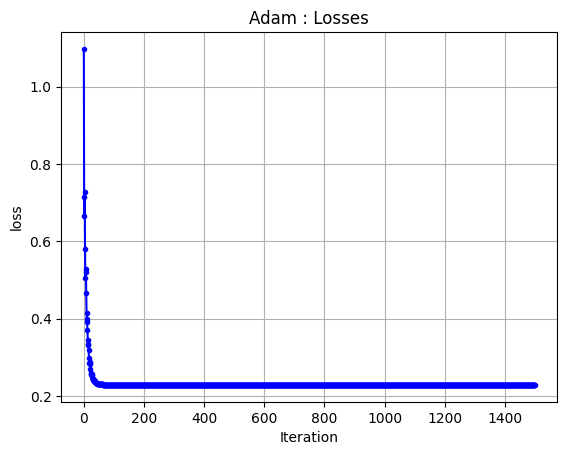

In [91]:
plt.figure()
plt.plot(losses_adam, marker=".", color="b", label="Loss")
plt.xlabel("Iteration")
plt.ylabel("loss")
plt.title("Adam : Losses")
# plt.legend(loc=2)
plt.grid(True)
plt.show()

In [84]:
y_train_adam = imp.sigmoid(np.dot(x_train, w_adam))
optimal_threshold = best_threshold(y_train_adam, y_train_split)  
print("Optimal Threshold for Adam", optimal_threshold)

Optimal Threshold for Adam 0.36


In [85]:
y_test_adam = imp.sigmoid(np.dot(x_test, w_adam))
y_test_adam = np.where(y_test_adam > optimal_threshold, 1, -1)

In [86]:
print("F1 score",f1_score_(y_test_split, y_test_adam))
print("Accuracy",accuracy_score_(y_test_split, y_test_adam))

F1 score 0.38456637168141594
Accuracy 0.8506639638556287


In [80]:
hlp.create_csv_submission(test_ids_, y_test_adam, "adam.csv")

### Logistic Regression with Regularization 

In [45]:
w_reg, best_params, losses = grid_search_reg_logistic_regression(y_train, x_train, param_grid, np.zeros(x_train.shape[1]))


Max Iters: 1500, Gamma: 1, Lambda: 0.0001, Avg Loss: 0.2297606158482602
Max Iters: 1500, Gamma: 1, Lambda: 1e-05, Avg Loss: 0.22976041756546514
Max Iters: 1500, Gamma: 1, Lambda: 1e-06, Avg Loss: 0.2297616920874618
Max Iters: 1500, Gamma: 0.1, Lambda: 0.0001, Avg Loss: 0.22993585946287043
Max Iters: 1500, Gamma: 0.1, Lambda: 1e-05, Avg Loss: 0.2298919415847535
Max Iters: 1500, Gamma: 0.1, Lambda: 1e-06, Avg Loss: 0.22988811346281293
Max Iters: 1500, Gamma: 0.001, Lambda: 0.0001, Avg Loss: 0.4900305808722318
Max Iters: 1500, Gamma: 0.001, Lambda: 1e-05, Avg Loss: 0.4900109562359458
Max Iters: 1500, Gamma: 0.001, Lambda: 1e-06, Avg Loss: 0.49000899364689304


In [46]:
print("Best hyperparameters found: ", best_params)

Best hyperparameters found:  {'max_iters': 1500, 'gamma': 1, 'lambda_': 1e-05}


In [92]:
w_reg, loss_reg = imp.reg_logistic_regression(y_train, x_train, 1e-05, np.zeros(x_train.shape[1]), 1500, 1)

# Find the optimal threshold

In [93]:
y_train_reg = imp.sigmoid(np.dot(x_train, w_reg))
optimal_threshold_reg = best_threshold(y_train_reg, y_train_split)  # y_train is (-1,1) and y_train_reg is (0,1)
print("Optimal threshold found for the regularized model: ", optimal_threshold_reg)

Optimal threshold found for the regularized model:  0.2


In [94]:
y_pred_reg = imp.sigmoid(np.dot(x_test, w_reg))
y_pred_reg = np.where(y_pred_reg > optimal_threshold_reg, 1, -1)


In [95]:
print("F1 score",f1_score_(y_test_split, y_pred_reg))
print("Accuracy",accuracy_score_(y_test_split, y_pred_reg))

F1 score 0.4119318181818182
Accuracy 0.8648709006888733
